In [1]:
import concurrent.futures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from src.plot import plot_qpp_vs_oracle_co2_subplot, plot_overhead_vs_oracle_grid
from src.experiment import run_scheduler_experiment
from src.stats import panel_configs_to_overhead_df

from config import *


In [8]:
CY_carbon_csv_path               = "./CI_data/CY_2024_5_minute.csv"
UK_carbon_csv_path               = "./CI_data/GB_2024_5_minute.csv"
BRA_carbon_csv_path              = "./CI_data/BR_2024_5_minute.csv"
AU_carbon_csv_path               = "./CI_data/AU_2024_5_minute.csv"

csv_list                         = [("United Kingdom",UK_carbon_csv_path), 
                                    ("Cyprus",CY_carbon_csv_path),  
                                    ("Brazil",BRA_carbon_csv_path), 
                                    ("Australia",AU_carbon_csv_path), 
                                   ]

VARIANCE_FACTOR = 1

def run_baseline(carbon_csv_path: str):
    base_results = []
    for scheduler in schedulers:
        if "fifo" in scheduler.name.lower():
            fifo_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="FIFO",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=baseline_GNN_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            base_results.append(fifo_result)
        else:
            gnn_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="GNN",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=baseline_GNN_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            rf_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="RF",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=baseline_RF_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            oracle_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="Oracle",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=baseline_RF_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                power_kw=POWER_CONSUMPTION,
                oracle=True,
                add_variance=VARIANCE_FACTOR,
            )
            base_results += [gnn_result, rf_result, oracle_result]
    return base_results

def run_local(carbon_csv_path: str):
    results = []
    for scheduler in schedulers:
        if "fifo" in scheduler.name.lower():
            fifo_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="FIFO",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=local_GNN_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            results.append(fifo_result)
        else:
            gnn_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="GNN",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=local_GNN_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            rf_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="RF",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=local_RF_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                upsample_to_sec=SLOT_SEC,
                power_kw=POWER_CONSUMPTION,
                oracle=False,
                add_variance=VARIANCE_FACTOR,
            )
            oracle_result = run_scheduler_experiment(
                name=f"{scheduler.name}",
                label="Oracle",
                scheduler=scheduler,
                carbon_csv_path=carbon_csv_path,
                values_csv_path=local_RF_values_csv_path,
                query_limit=NUM_QUERIES,
                use_lifecycle_ci=USE_LIFECYCLE,
                start_date=START_DATE,
                end_date=END_DATE,
                start_time=TIME,
                end_time=TIME,
                power_kw=POWER_CONSUMPTION,
                oracle=True,
                add_variance=VARIANCE_FACTOR,
            )
            results += [gnn_result, rf_result, oracle_result]
    return results

def run_all_locations():
    baseline_panels = []
    lowvar_panels = []

    for location_name, ci_path in csv_list:
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future_baseline = executor.submit(run_baseline, ci_path)
            future_local    = executor.submit(run_local,    ci_path)

            base_results  = future_baseline.result()
            local_results = future_local.result()

        baseline_panels.append((location_name, "Baseline Variance", base_results))
        lowvar_panels.append((location_name, "Reduced Variance", local_results))

    panel_configs = baseline_panels + lowvar_panels
    return panel_configs

panel_configs = run_all_locations()  

Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   259.97
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   185.72
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   174.30
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   169.20
Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   154.07
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   115.75
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   114.27
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   114.13
Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   773.83
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   616.39
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   584.73
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   562.31
Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   433.41
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   291.77
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   288.04
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   287.32
Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   125.30
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   130.85
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   128.92
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   127.49
Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   68.87
Experiment Name:        Greedy Delay (GNN)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   67.08
Experiment Name:        Greedy Delay (RF)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   66.21
Experiment Name:        Greedy Delay (Oracle)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   66.14
Experiment Name:        FIFO (FIFO)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Total carbon (gCO2):   409.66
Experiment Name:        Greedy Delay (GNN)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   382.05
Experiment Name:        Greedy Delay (RF)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   376.33
Experiment Name:        Greedy Delay (Oracle)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   373.48


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Experiment Name:        FIFO (FIFO)
Total carbon (gCO2):   270.66
Experiment Name:        Greedy Delay (GNN)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   175.87
Experiment Name:        Greedy Delay (RF)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   173.59
Experiment Name:        Greedy Delay (Oracle)


/mnt/primary/Mini-project/Apache/System/Carbon_Scheduling/offline/src/carbon.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Greedy Delay (queries):   0%|          | 0/750 [00:00<?, ?query/s]

Total carbon (gCO2):   173.21


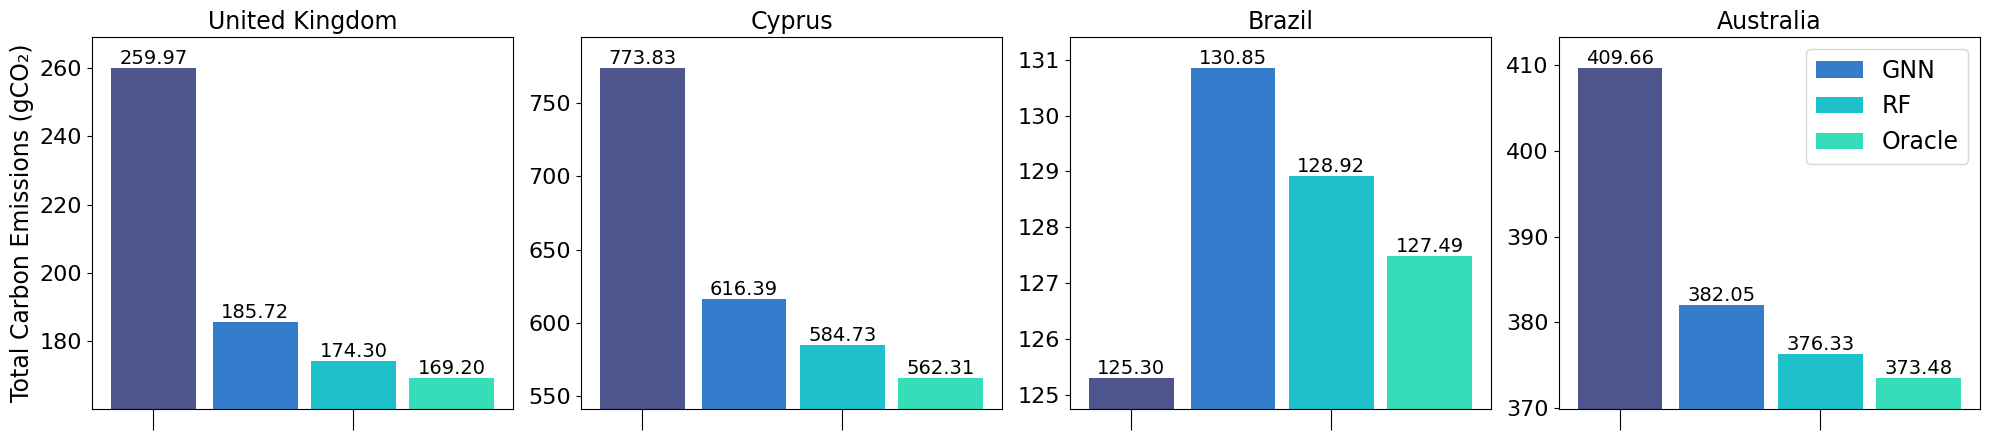

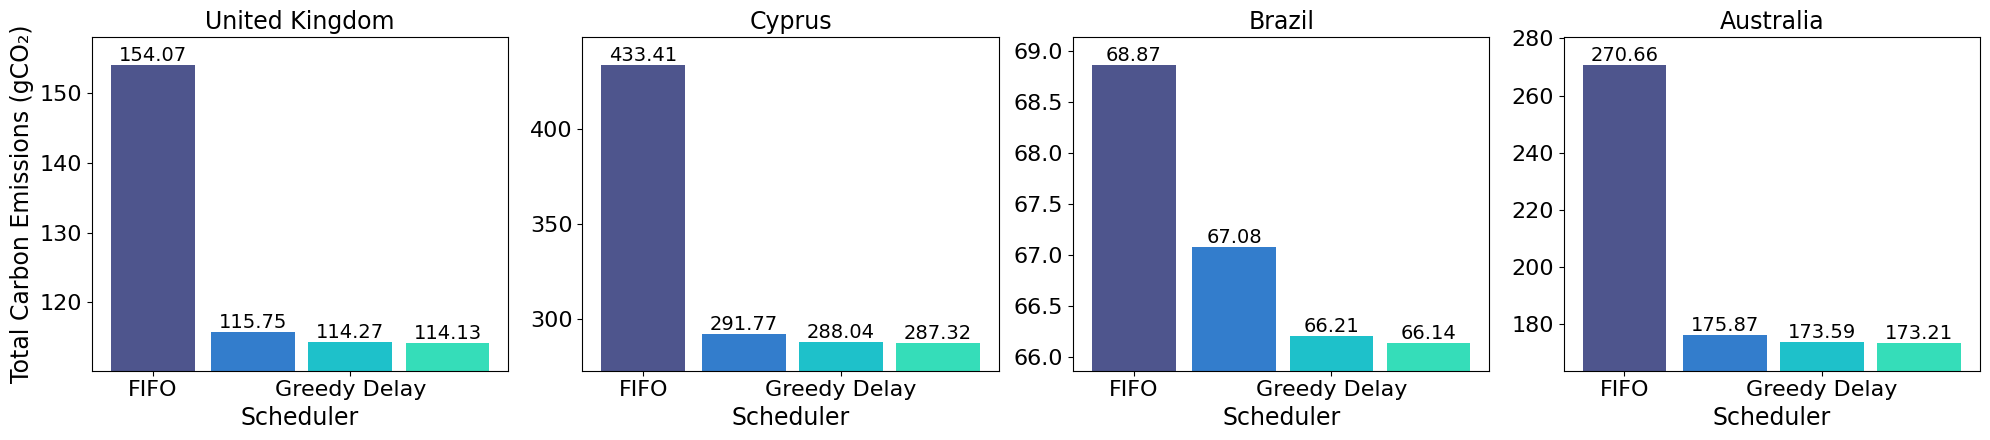

In [9]:
# Raw results plotting

colour_map = {
    "FIFO":   "#4e558d",
    "GNN":    "#337dcc",
    "RF":     "#1ec1ca",
    "Oracle": "#35ddb9",
}

baseline_configs = [cfg for cfg in panel_configs if cfg[1] == "Baseline Variance"]
reduced_configs  = [cfg for cfg in panel_configs if cfg[1] == "Reduced Variance"]

fig_base, axes_base = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

for idx, (ax, (location, variant, res_list)) in enumerate(
    zip(axes_base, baseline_configs)
):
    plot_qpp_vs_oracle_co2_subplot(
        ax,
        res_list,
        location=location,
        variant=variant,
        show_legend=(location == "Australia"),
        legend_size=17,
        color_map=colour_map,
        ticks=False,
    )
    if idx != 0:
        ax.set_ylabel("")

fig_base.tight_layout(rect=[0, 0, 1, 0.90])
fig_base.savefig("Total_emissions_Baseline.pdf", dpi=300, bbox_inches="tight")

fig_red, axes_red = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

for idx, (ax, (location, variant, res_list)) in enumerate(
    zip(axes_red, reduced_configs)
):
    plot_qpp_vs_oracle_co2_subplot(
        ax,
        res_list,
        location=location,
        variant=variant,
        show_legend=False,
        legend_size=17,
        color_map=colour_map,
    )

    if idx != 0:
        ax.set_ylabel("")

fig_red.tight_layout(rect=[0, 0, 1, 0.90])
fig_red.savefig("Total_emissions_Reduced.pdf", dpi=300, bbox_inches="tight")

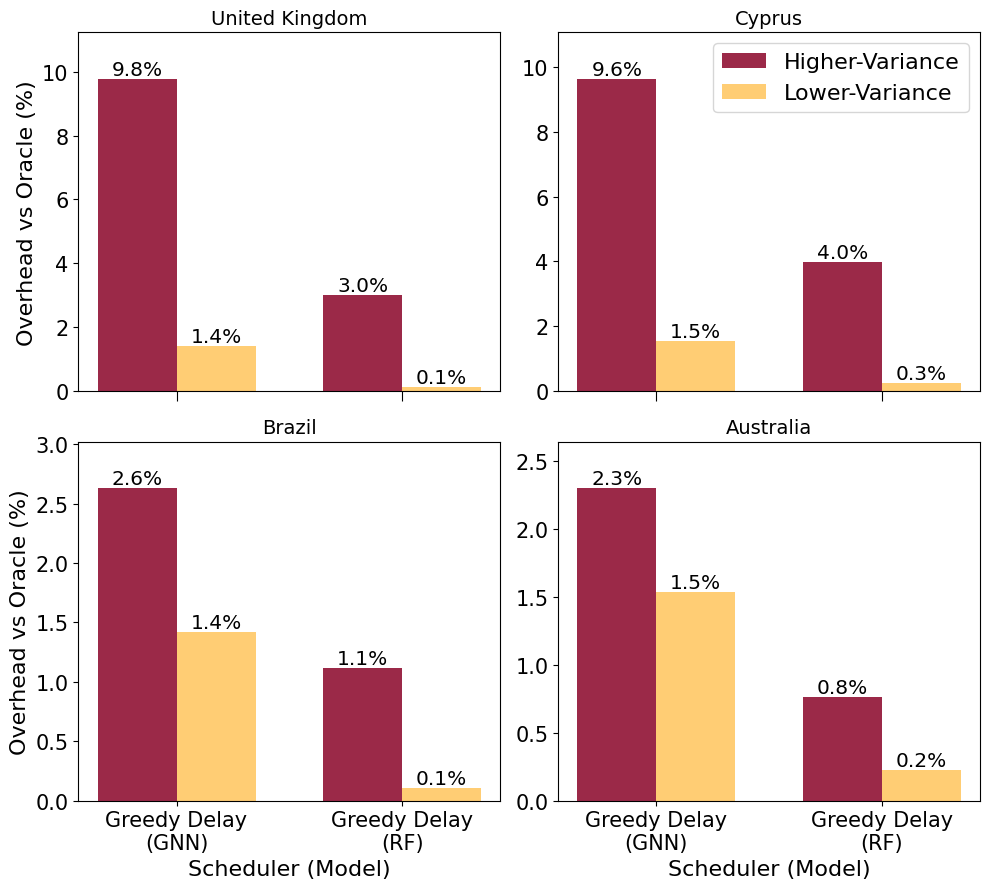

In [15]:
# Overhead results plotting

overhead_df = panel_configs_to_overhead_df(panel_configs, metric="carbon_total_gco2")
colour_map = {#3a4280
        "baseline":   "#9b2948",  
        "local":    "#ffcd74",  
    }

overhead_df["scenario"] = overhead_df["scenario"].replace({
    "Baseline Variance": "Higher-Variance",
    "Reduced Variance":  "Lower-Variance",
})
        
plot_overhead_vs_oracle_grid(
    overhead_df,
    baseline_scenario="Higher-Variance",
    compare_scenario="Lower-Variance",
    schedulers=["Greedy Delay"],
    models=("GNN", "RF"),
    color_map = colour_map,
)